# Clustering CD34 image features with PhenoGraph

#### This notebook uses the matrix of 672 features per single cell CD34 channel cropped image to cluster the cells and identify which are leukemia cells based on clustering pattern

## Importing

In [2]:
import warnings
# To ignore Pandas Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
%matplotlib inline

In [3]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
print("phenograph==", phenograph.__version__)
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7
phenograph== 1.5.7


In [4]:
from os import listdir
from os.path import isfile, join

In [5]:
pt = 'P56'

### Read in counts tables to obtain raw marker expression per cell

In [5]:
# read in counts tables from each fov
counts_dir = '/data/Zhaolab/1_AMLCosMx/Final_scripts/3_GenerateCounts/' + pt + '_hybrid_counts/'
tables = [f for f in listdir(counts_dir) if isfile(join(counts_dir, f))]
tables.sort()

In [6]:
# create all-fov counts table
all_fovs = pd.read_csv(counts_dir + tables[0], index_col=0, comment='#')

for i in range(1,len(tables)):
    data = pd.read_csv(counts_dir + tables[i], index_col=0, comment='#')
    all_fovs = pd.concat([all_fovs, data])

# add column to sepecify patient
all_fovs['Patient'] = pt
# convert FOV number to 2-digit string
all_fovs['fov'] = all_fovs['fov'].astype(str).str.zfill(2)
all_fovs['cell_ID'] = all_fovs['cell_ID'].astype(int)
all_fovs.head()

fov  cell_ID   x_global_px   y_global_px  x_local_px  y_local_px  z  \
0  01      181  58383.678889  28584.122222     4144.79     3411.90  0   
1  01        0  55420.868889  28349.222222     1181.98     3177.00  0   
2  01     1950  57503.768889  26760.782222     3264.88     1588.56  0   
3  01     2990  58093.218889  25548.532222     3854.33      376.31  0   
4  01        0  59259.918889  28176.222222     5021.03     3004.00  0   

    target  Size (pixels)   CD298_total  ...    CD45_total    CD45_mean  \
0   S100A8           2320  7.997430e+06  ...  2.303149e+06   992.736686   
1    EPHB2              0  0.000000e+00  ...  0.000000e+00     0.000000   
2  CEACAM1           5840  2.416543e+07  ...  7.313954e+06  1252.389346   
3   SEC61G            632  1.497649e+06  ...  6.721016e+05  1063.451828   
4    KRT80              0  0.000000e+00  ...  0.000000e+00     0.000000   

   CD45_median    CD34_total    CD34_mean  CD34_median    DAPI_total  \
0   989.555556  2.544655e+06  1096.833908  1086.722222  1.659469e+06   
1     0.000000  0.000000e+00     0.000000     0.000000  0.000000e+00   
2  1126.388889  1.303919e+07  2232.737329  1451.444444  8.279941e+06   
3  1009.000000  7.447444e+05  1178.393108  1169.555556  3.238559e+05   
4     0.000000  0.000000e+00     0.000000     0.000000  0.000000e+00   

     DAPI_mean  DAPI_median  Patient  
0   715.288218   679.000000      P56  
1     0.000000     0.000000      P56  
2  1417.798059  1042.555556      P56  
3   512.430204   504.722222      P56  
4     0.000000     0.000000      P56  

[5 rows x 25 columns]

In [7]:
# create unique ID for each cell (patient + FOV + cell number)
all_fovs['New_ID'] = all_fovs['Patient'] + '_FOV' + all_fovs['fov'] + "_cell_" + all_fovs["cell_ID"].astype(str)
all_fovs

fov  cell_ID   x_global_px   y_global_px  x_local_px  y_local_px  z  \
0         01      181  58383.678889  28584.122222     4144.79     3411.90  0   
1         01        0  55420.868889  28349.222222     1181.98     3177.00  0   
2         01     1950  57503.768889  26760.782222     3264.88     1588.56  0   
3         01     2990  58093.218889  25548.532222     3854.33      376.31  0   
4         01        0  59259.918889  28176.222222     5021.03     3004.00  0   
...       ..      ...           ...           ...         ...         ... ..   
14799336  25     5485 -37882.486667 -15433.494444     2284.18       10.95  4   
14799337  25     5485 -37888.266667 -15428.424444     2278.40       16.02  4   
14799338  25        0 -37879.376667 -15424.844444     2287.29       19.60  5   
14799339  25     5485 -37887.666667 -15427.804444     2279.00       16.64  5   
14799340  25        0 -36589.246667 -15431.604444     3577.42       12.84  0   

           target  Size (pixels)   CD298_total  ...    CD45_mean  CD45_median  \
0          S100A8           2320  7.997430e+06  ...   992.736686   989.555556   
1           EPHB2              0  0.000000e+00  ...     0.000000     0.000000   
2         CEACAM1           5840  2.416543e+07  ...  1252.389346  1126.388889   
3          SEC61G            632  1.497649e+06  ...  1063.451828  1009.000000   
4           KRT80              0  0.000000e+00  ...     0.000000     0.000000   
...           ...            ...           ...  ...          ...          ...   
14799336    CCL20            595  8.795888e+05  ...  1154.339122  1152.444444   
14799337     HBA1            595  8.795888e+05  ...  1154.339122  1152.444444   
14799338    EFNA4              0  0.000000e+00  ...     0.000000     0.000000   
14799339     HBA1            595  8.795888e+05  ...  1154.339122  1152.444444   
14799340     AZU1              0  0.000000e+00  ...     0.000000     0.000000   

            CD34_total    CD34_mean  CD34_median    DAPI_total    DAPI_mean  \
0         2.544655e+06  1096.833908  1086.722222  1.659469e+06   715.288218   
1         0.000000e+00     0.000000     0.000000  0.000000e+00     0.000000   
2         1.303919e+07  2232.737329  1451.444444  8.279941e+06  1417.798059   
3         7.447444e+05  1178.393108  1169.555556  3.238559e+05   512.430204   
4         0.000000e+00     0.000000     0.000000  0.000000e+00     0.000000   
...                ...          ...          ...           ...          ...   
14799336  8.456261e+05  1421.220355  1408.222222  1.251019e+05   210.255275   
14799337  8.456261e+05  1421.220355  1408.222222  1.251019e+05   210.255275   
14799338  0.000000e+00     0.000000     0.000000  0.000000e+00     0.000000   
14799339  8.456261e+05  1421.220355  1408.222222  1.251019e+05   210.255275   
14799340  0.000000e+00     0.000000     0.000000  0.000000e+00     0.000000   

          DAPI_median  Patient               New_ID  
0          679.000000      P56   P56_FOV01_cell_181  
1            0.000000      P56     P56_FOV01_cell_0  
2         1042.555556      P56  P56_FOV01_cell_1950  
3          504.722222      P56  P56_FOV01_cell_2990  
4            0.000000      P56     P56_FOV01_cell_0  
...               ...      ...                  ...  
14799336   197.555556      P56  P56_FOV25_cell_5485  
14799337   197.555556      P56  P56_FOV25_cell_5485  
14799338     0.000000      P56     P56_FOV25_cell_0  
14799339   197.555556      P56  P56_FOV25_cell_5485  
14799340     0.000000      P56     P56_FOV25_cell_0  

[14799341 rows x 26 columns]

In [8]:
# since current table has each row as a transcript read, remove duplicates so we have 1 entry per cell
all_fovs = all_fovs.drop_duplicates(subset='New_ID', keep='first', ignore_index=True)
all_fovs

fov  cell_ID   x_global_px   y_global_px  x_local_px  y_local_px  z  \
0      01      181  58383.678889  28584.122222     4144.79   3411.9000  0   
1      01        0  55420.868889  28349.222222     1181.98   3177.0000  0   
2      01     1950  57503.768889  26760.782222     3264.88   1588.5600  0   
3      01     2990  58093.218889  25548.532222     3854.33    376.3100  0   
4      01       29  55795.878889  28778.134722     1556.99   3605.9125  0   
...    ..      ...           ...           ...         ...         ... ..   
86180  25     5487 -38998.296667 -15432.064444     1168.37     12.3800  2   
86181  25     5483 -38573.326667 -15428.764444     1593.34     15.6800  0   
86182  25     5486 -37816.376667 -15427.094444     2350.29     17.3500  1   
86183  25     2201 -36040.246667 -15433.654444     4126.42     10.7900  1   
86184  25     5485 -37893.526667 -15430.074444     2273.14     14.3700  1   

        target  Size (pixels)   CD298_total  ...    CD45_mean  CD45_median  \
0       S100A8           2320  7.997430e+06  ...   992.736686   989.555556   
1        EPHB2              0  0.000000e+00  ...     0.000000     0.000000   
2      CEACAM1           5840  2.416543e+07  ...  1252.389346  1126.388889   
3       SEC61G            632  1.497649e+06  ...  1063.451828  1009.000000   
4       ADGRE2           4001  8.270455e+06  ...   902.296620   885.111111   
...        ...            ...           ...  ...          ...          ...   
86180    FGF13            481  1.575147e+06  ...  1799.191961  1524.888889   
86181    IGHG1            624  1.763831e+06  ...  1629.380698  1560.555556   
86182     KRT8            810  1.288639e+06  ...  1512.843347  1332.500000   
86183     FGF9            780  1.345983e+06  ...  1116.565100  1113.444444   
86184      HBB            595  8.795888e+05  ...  1154.339122  1152.444444   

         CD34_total    CD34_mean  CD34_median    DAPI_total    DAPI_mean  \
0      2.544655e+06  1096.833908  1086.722222  1.659469e+06   715.288218   
1      0.000000e+00     0.000000     0.000000  0.000000e+00     0.000000   
2      1.303919e+07  2232.737329  1451.444444  8.279941e+06  1417.798059   
3      7.447444e+05  1178.393108  1169.555556  3.238559e+05   512.430204   
4      3.672920e+06   918.000417   911.333333  4.985065e+06  1245.954650   
...             ...          ...          ...           ...          ...   
86180  1.976975e+06  4110.134904  2718.111111  1.581608e+05   328.816586   
86181  2.196303e+06  3519.715634  3044.888889  1.616394e+05   259.037571   
86182  2.895769e+06  3575.023182  2093.277778  2.018646e+05   249.215501   
86183  1.132378e+06  1451.766239  1445.277778  1.897483e+05   243.267094   
86184  8.456261e+05  1421.220355  1408.222222  1.251019e+05   210.255275   

       DAPI_median  Patient               New_ID  
0       679.000000      P56   P56_FOV01_cell_181  
1         0.000000      P56     P56_FOV01_cell_0  
2      1042.555556      P56  P56_FOV01_cell_1950  
3       504.722222      P56  P56_FOV01_cell_2990  
4      1264.222222      P56    P56_FOV01_cell_29  
...            ...      ...                  ...  
86180   279.222222      P56  P56_FOV25_cell_5487  
86181   259.055556      P56  P56_FOV25_cell_5483  
86182   216.333333      P56  P56_FOV25_cell_5486  
86183   237.111111      P56  P56_FOV25_cell_2201  
86184   197.555556      P56  P56_FOV25_cell_5485  

[86185 rows x 26 columns]

In [9]:
# 0 does not correspond to a real cell, drop from DF
all_fovs_metadata = all_fovs.drop(all_fovs[all_fovs['cell_ID'] == 0].index)

In [10]:
# set unique cell ID as DF index
all_fovs_metadata = all_fovs_metadata.set_index('New_ID')
all_fovs_metadata.head()

fov  cell_ID   x_global_px   y_global_px  x_local_px  \
New_ID                                                                     
P56_FOV01_cell_181   01      181  58383.678889  28584.122222     4144.79   
P56_FOV01_cell_1950  01     1950  57503.768889  26760.782222     3264.88   
P56_FOV01_cell_2990  01     2990  58093.218889  25548.532222     3854.33   
P56_FOV01_cell_29    01       29  55795.878889  28778.134722     1556.99   
P56_FOV01_cell_4112  01     4112  57368.338889  28048.222222     3129.45   

                     y_local_px  z   target  Size (pixels)   CD298_total  ...  \
New_ID                                                                    ...   
P56_FOV01_cell_181    3411.9000  0   S100A8           2320  7.997430e+06  ...   
P56_FOV01_cell_1950   1588.5600  0  CEACAM1           5840  2.416543e+07  ...   
P56_FOV01_cell_2990    376.3100  0   SEC61G            632  1.497649e+06  ...   
P56_FOV01_cell_29     3605.9125  0   ADGRE2           4001  8.270455e+06  ...   
P56_FOV01_cell_4112   2876.0000  0      SMO           3225  4.997969e+06  ...   

                       CD45_total    CD45_mean  CD45_median    CD34_total  \
New_ID                                                                      
P56_FOV01_cell_181   2.303149e+06   992.736686   989.555556  2.544655e+06   
P56_FOV01_cell_1950  7.313954e+06  1252.389346  1126.388889  1.303919e+07   
P56_FOV01_cell_2990  6.721016e+05  1063.451828  1009.000000  7.447444e+05   
P56_FOV01_cell_29    3.610089e+06   902.296620   885.111111  3.672920e+06   
P56_FOV01_cell_4112  2.894027e+06   897.372713   890.444444  3.581136e+06   

                       CD34_mean  CD34_median    DAPI_total    DAPI_mean  \
New_ID                                                                     
P56_FOV01_cell_181   1096.833908  1086.722222  1.659469e+06   715.288218   
P56_FOV01_cell_1950  2232.737329  1451.444444  8.279941e+06  1417.798059   
P56_FOV01_cell_2990  1178.393108  1169.555556  3.238559e+05   512.430204   
P56_FOV01_cell_29     918.000417   911.333333  4.985065e+06  1245.954650   
P56_FOV01_cell_4112  1110.429664  1101.444444  4.901483e+06  1519.839690   

                     DAPI_median  Patient  
New_ID                                     
P56_FOV01_cell_181    679.000000      P56  
P56_FOV01_cell_1950  1042.555556      P56  
P56_FOV01_cell_2990   504.722222      P56  
P56_FOV01_cell_29    1264.222222      P56  
P56_FOV01_cell_4112  1689.666667      P56  

[5 rows x 25 columns]

### Read in feature matrix as csv

In [11]:
# read in features from each fov
feats_dir = 'Normalized_CD34_feats/'
tables = [f for f in listdir(feats_dir) if isfile(join(feats_dir, f))]
tables.sort()

In [12]:
# create all-fov feats table
all_fovs = pd.read_csv(feats_dir + tables[0], index_col=0)

for i in range(1,len(tables)):
    data = pd.read_csv(feats_dir + tables[i], index_col=0)
    all_fovs = pd.concat([all_fovs, data])
    
all_fovs

0         1         2         3         4  \
P56_FOV01_cell_1     0.396579  2.722420  3.154098  2.698923  0.547192   
P56_FOV01_cell_2     0.438842  2.454708  3.108408  2.520660  0.548036   
P56_FOV01_cell_3     0.425369  2.725788  3.064819  2.727907  0.583406   
P56_FOV01_cell_4     0.416652  2.728108  3.121831  2.726971  0.601674   
P56_FOV01_cell_5     0.414423  2.689512  3.154219  2.736420  0.551976   
...                       ...       ...       ...       ...       ...   
P56_FOV25_cell_5487  0.401837  2.671860  3.148478  2.719974  0.541118   
P56_FOV25_cell_5488  0.404904  2.675097  3.191312  2.746453  0.529044   
P56_FOV25_cell_5490  0.405171  2.675288  3.191123  2.746517  0.529236   
P56_FOV25_cell_5491  0.404790  2.675193  3.191385  2.746416  0.528990   
P56_FOV25_cell_5492  0.404804  2.675177  3.191376  2.746421  0.528997   

                            5         6         7         8         9  ...  \
P56_FOV01_cell_1     0.426518  2.275810  0.175882  0.804922  0.282863  ...   
P56_FOV01_cell_2     0.460305  2.233897 -0.153091  0.826836  0.468741  ...   
P56_FOV01_cell_3     0.375126  2.312025  0.091857  0.845765  0.276523  ...   
P56_FOV01_cell_4     0.386355  2.294608  0.246096  0.910506  0.279551  ...   
P56_FOV01_cell_5     0.373849  2.339359  0.058495  0.820625  0.277223  ...   
...                       ...       ...       ...       ...       ...  ...   
P56_FOV25_cell_5487  0.373810  2.360803 -0.136027  0.783718  0.276596  ...   
P56_FOV25_cell_5488  0.363450  2.389116 -0.162251  0.791276  0.274637  ...   
P56_FOV25_cell_5490  0.363351  2.388897 -0.162221  0.791301  0.274631  ...   
P56_FOV25_cell_5491  0.363454  2.389145 -0.162254  0.791261  0.274641  ...   
P56_FOV25_cell_5492  0.363455  2.389143 -0.162254  0.791263  0.274641  ...   

                          662       663       664       665       666  \
P56_FOV01_cell_1     0.513121 -0.058197  0.367962 -0.020022  1.726691   
P56_FOV01_cell_2     0.520657 -0.024739  0.515346  0.032177  1.730150   
P56_FOV01_cell_3     0.534428 -0.050636  0.232661 -0.018284  1.707645   
P56_FOV01_cell_4     0.530639 -0.052702  0.280587 -0.020004  1.707917   
P56_FOV01_cell_5     0.527263 -0.052672  0.187330 -0.019447  1.718794   
...                       ...       ...       ...       ...       ...   
P56_FOV25_cell_5487  0.519138 -0.049189  0.179029 -0.019191  1.736751   
P56_FOV25_cell_5488  0.533383 -0.050070  0.060073 -0.030631  1.726160   
P56_FOV25_cell_5490  0.533831 -0.050122  0.059725 -0.030559  1.725848   
P56_FOV25_cell_5491  0.533213 -0.050048  0.060137 -0.030624  1.726255   
P56_FOV25_cell_5492  0.533236 -0.050051  0.060130 -0.030626  1.726244   

                          667       668       669       670       671  
P56_FOV01_cell_1     0.158419  3.464756 -0.050792  0.592588 -0.041792  
P56_FOV01_cell_2     0.157906  3.489481 -0.022850  0.566276 -0.020460  
P56_FOV01_cell_3     0.170805  3.463796 -0.044115  0.624299 -0.062564  
P56_FOV01_cell_4     0.166104  3.464791 -0.027408  0.612422 -0.061923  
P56_FOV01_cell_5     0.154908  3.458752 -0.052781  0.620894 -0.052566  
...                       ...       ...       ...       ...       ...  
P56_FOV25_cell_5487  0.150985  3.468206 -0.056050  0.598517 -0.035643  
P56_FOV25_cell_5488  0.147983  3.447033 -0.079056  0.620888 -0.041425  
P56_FOV25_cell_5490  0.148054  3.447284 -0.078765  0.621565 -0.041488  
P56_FOV25_cell_5491  0.147950  3.446966 -0.079221  0.620731 -0.041409  
P56_FOV25_cell_5492  0.147954  3.446974 -0.079198  0.620749 -0.041411  

[86344 rows x 672 columns]

In [13]:
# concatenate individual FOV feature tables as 1 large feature table
all_fovs.to_csv(pt + "_all_cell_CD34_features.csv", header=False)

In [14]:
# read in feature matrix as anndata object for clustering
adata = sc.read_csv(pt + "_all_cell_CD34_features.csv", first_column_names=True)
adata

AnnData object with n_obs × n_vars = 86344 × 672

In [15]:
adata.obs

Empty DataFrame
Columns: []
Index: [P56_FOV01_cell_1, P56_FOV01_cell_2, P56_FOV01_cell_3, P56_FOV01_cell_4, P56_FOV01_cell_5, P56_FOV01_cell_6, P56_FOV01_cell_7, P56_FOV01_cell_8, P56_FOV01_cell_9, P56_FOV01_cell_10, P56_FOV01_cell_11, P56_FOV01_cell_12, P56_FOV01_cell_13, P56_FOV01_cell_14, P56_FOV01_cell_15, P56_FOV01_cell_16, P56_FOV01_cell_17, P56_FOV01_cell_18, P56_FOV01_cell_19, P56_FOV01_cell_20, P56_FOV01_cell_21, P56_FOV01_cell_22, P56_FOV01_cell_23, P56_FOV01_cell_24, P56_FOV01_cell_25, P56_FOV01_cell_26, P56_FOV01_cell_27, P56_FOV01_cell_28, P56_FOV01_cell_29, P56_FOV01_cell_30, P56_FOV01_cell_31, P56_FOV01_cell_32, P56_FOV01_cell_33, P56_FOV01_cell_34, P56_FOV01_cell_35, P56_FOV01_cell_36, P56_FOV01_cell_37, P56_FOV01_cell_38, P56_FOV01_cell_39, P56_FOV01_cell_40, P56_FOV01_cell_41, P56_FOV01_cell_42, P56_FOV01_cell_43, P56_FOV01_cell_44, P56_FOV01_cell_45, P56_FOV01_cell_46, P56_FOV01_cell_47, P56_FOV01_cell_48, P56_FOV01_cell_49, P56_FOV01_cell_50, P56_FOV01_cell_51, P56_FOV01_cell_52, P56_FOV01_cell_53, P56_FOV01_cell_54, P56_FOV01_cell_55, P56_FOV01_cell_56, P56_FOV01_cell_57, P56_FOV01_cell_58, P56_FOV01_cell_59, P56_FOV01_cell_60, P56_FOV01_cell_61, P56_FOV01_cell_62, P56_FOV01_cell_63, P56_FOV01_cell_64, P56_FOV01_cell_65, P56_FOV01_cell_66, P56_FOV01_cell_67, P56_FOV01_cell_68, P56_FOV01_cell_69, P56_FOV01_cell_70, P56_FOV01_cell_71, P56_FOV01_cell_72, P56_FOV01_cell_73, P56_FOV01_cell_74, P56_FOV01_cell_75, P56_FOV01_cell_76, P56_FOV01_cell_77, P56_FOV01_cell_78, P56_FOV01_cell_79, P56_FOV01_cell_80, P56_FOV01_cell_81, P56_FOV01_cell_82, P56_FOV01_cell_83, P56_FOV01_cell_84, P56_FOV01_cell_85, P56_FOV01_cell_86, P56_FOV01_cell_87, P56_FOV01_cell_88, P56_FOV01_cell_89, P56_FOV01_cell_90, P56_FOV01_cell_91, P56_FOV01_cell_92, P56_FOV01_cell_93, P56_FOV01_cell_94, P56_FOV01_cell_95, P56_FOV01_cell_96, P56_FOV01_cell_97, P56_FOV01_cell_98, P56_FOV01_cell_99, P56_FOV01_cell_100, ...]

[86344 rows x 0 columns]

In [16]:
# load FOV metadata
FOV_metadata = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/FOV_metadata.csv', index_col=0)
FOV_metadata

Timepoint Clinical outcome
P51_FOV01         A               PD
P51_FOV02         A               PD
P51_FOV03         A               PD
P51_FOV04         A               PD
P51_FOV05         A               PD
...             ...              ...
P58_FOV19         C               SD
P58_FOV20         C               SD
P58_FOV21         C               SD
P58_FOV22         C               SD
P58_FOV23         C               SD

[141 rows x 2 columns]

In [17]:
# get FOV and cell number from cell ID, timepoint from csv file

adata.obs['FOV'] = ''
adata.obs['cell_ID'] = 0
adata.obs['Timepoint'] = ''

for i in range(adata.obs.shape[0]):
    adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
    adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')
    adata.obs['Timepoint'].iloc[i] = FOV_metadata['Timepoint'].loc[adata.obs.iloc[i].name[0:9]]

adata.obs

/tmp/ipykernel_1829720/3782544952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
/tmp/ipykernel_1829720/3782544952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')


FOV cell_ID Timepoint
P56_FOV01_cell_1     01       1         A
P56_FOV01_cell_2     01       2         A
P56_FOV01_cell_3     01       3         A
P56_FOV01_cell_4     01       4         A
P56_FOV01_cell_5     01       5         A
...                  ..     ...       ...
P56_FOV25_cell_5487  25    5487         C
P56_FOV25_cell_5488  25    5488         C
P56_FOV25_cell_5490  25    5490         C
P56_FOV25_cell_5491  25    5491         C
P56_FOV25_cell_5492  25    5492         C

[86344 rows x 3 columns]

### Map protein expression values to appropriate cell IDs in feature table

In [18]:
adata.obs = adata.obs.merge(all_fovs_metadata[['Size (pixels)', 'CD34_median']], how='left', left_index=True, right_index=True)
adata.obs

FOV cell_ID Timepoint  Size (pixels)  CD34_median
P56_FOV01_cell_1     01       1         A         1867.0   903.888889
P56_FOV01_cell_2     01       2         A         2089.0  9282.555556
P56_FOV01_cell_3     01       3         A         3950.0   800.555556
P56_FOV01_cell_4     01       4         A         2886.0   867.611111
P56_FOV01_cell_5     01       5         A          818.0   881.777778
...                  ..     ...       ...            ...          ...
P56_FOV25_cell_5487  25    5487         C          481.0  2718.111111
P56_FOV25_cell_5488  25    5488         C          434.0  1655.722222
P56_FOV25_cell_5490  25    5490         C            NaN          NaN
P56_FOV25_cell_5491  25    5491         C          423.0  1174.333333
P56_FOV25_cell_5492  25    5492         C            NaN          NaN

[86344 rows x 5 columns]

## Pre-Processing

### Log-Transformation

In [19]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [20]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

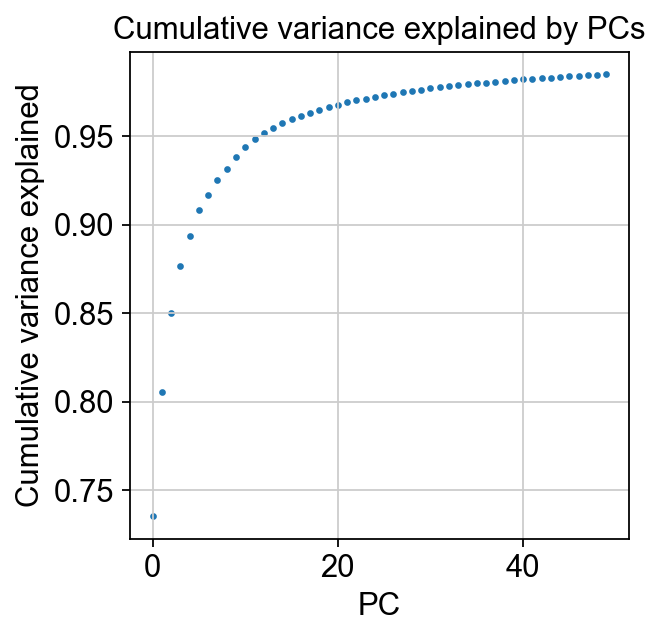

In [21]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [22]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [23]:
k = 25 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 25 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 176.34388828277588 seconds
Jaccard graph constructed in 42.17248558998108 seconds
Wrote graph to binary file in 2.336905002593994 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.93691
After 2 runs, maximum modularity is Q = 0.938275
Louvain completed 22 runs in 151.19470286369324 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 395.7740089893341 seconds


In [24]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


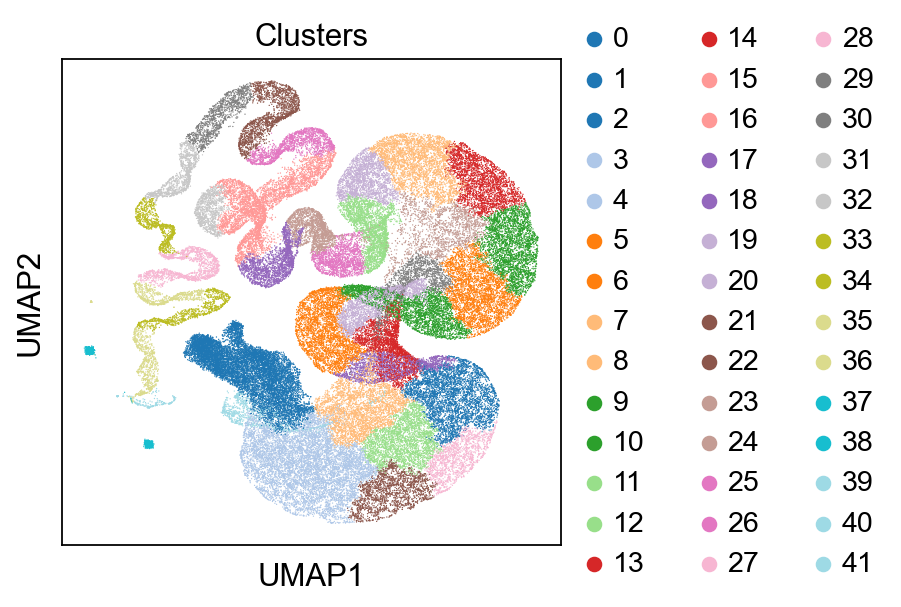

In [25]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

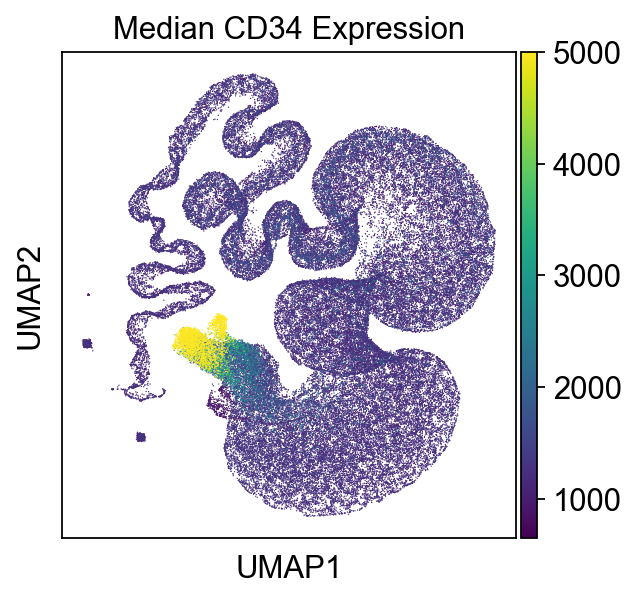

In [26]:
sc.pl.umap(
    adata, 
    color=['CD34_median'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Median CD34 Expression"],
    vmax=5000
)

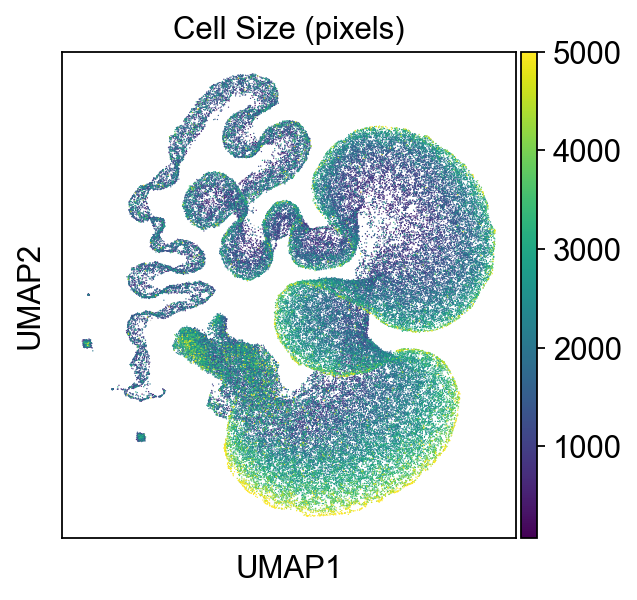

In [27]:
sc.pl.umap(
    adata, 
    color=['Size (pixels)'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Cell Size (pixels)"],
    vmax=5000
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


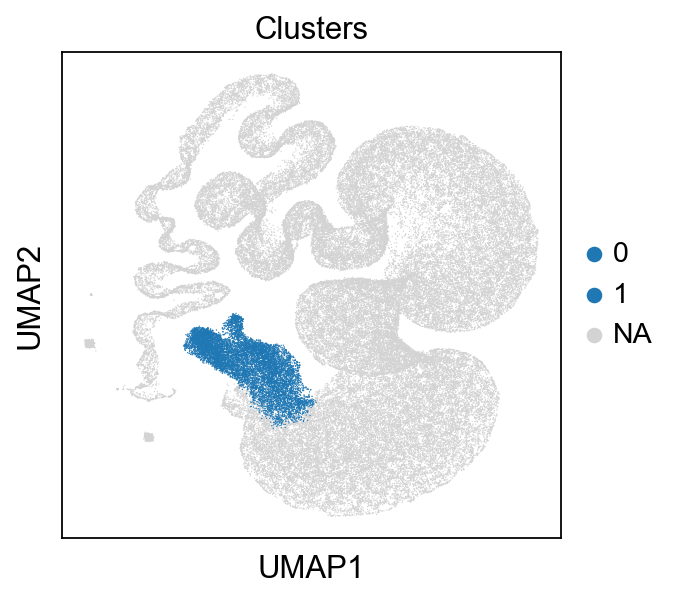

In [29]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[0,1]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


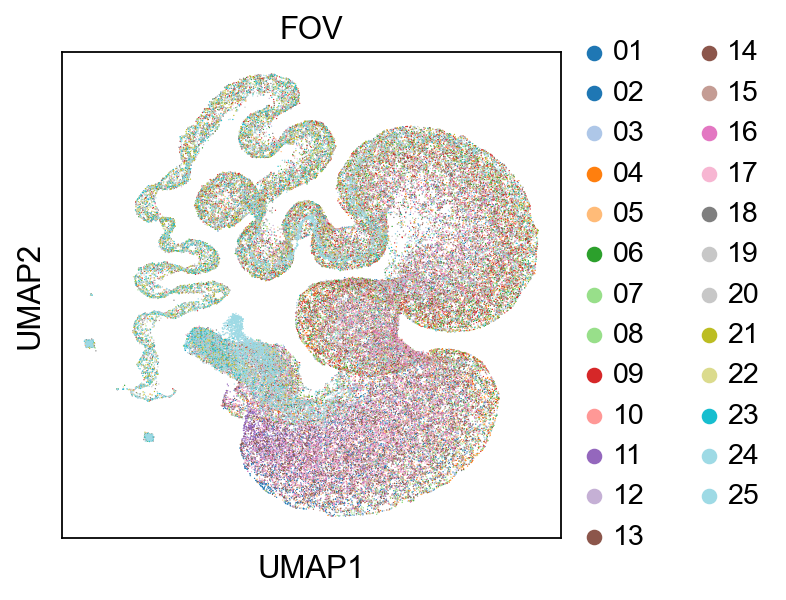

In [30]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [31]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv(pt + '_CD34_clusters.csv')

In [32]:
adata_all = adata

In [33]:
# save clustered data anndata object
adata_all.write_h5ad(pt + '_CD34_cell_features_clustered.h5ad')

## Sub-cluster CD34+ candidates (cluster 0,1)

In [34]:
adata = adata[adata.obs['PhenoGraph_clusters'].isin([0,1])]
adata.obs = adata.obs.rename(columns={"PhenoGraph_clusters": "PhenoGraph_clusters_round_1"})
adata

AnnData object with n_obs × n_vars = 10098 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint', 'Size (pixels)', 'CD34_median', 'PhenoGraph_clusters_round_1'
    uns: 'pca', 'PhenoGraph_Q', 'PhenoGraph_k', 'neighbors', 'umap', 'PhenoGraph_clusters_colors', 'FOV_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Pre-Processing

### Log-Transformation

In [35]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [36]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

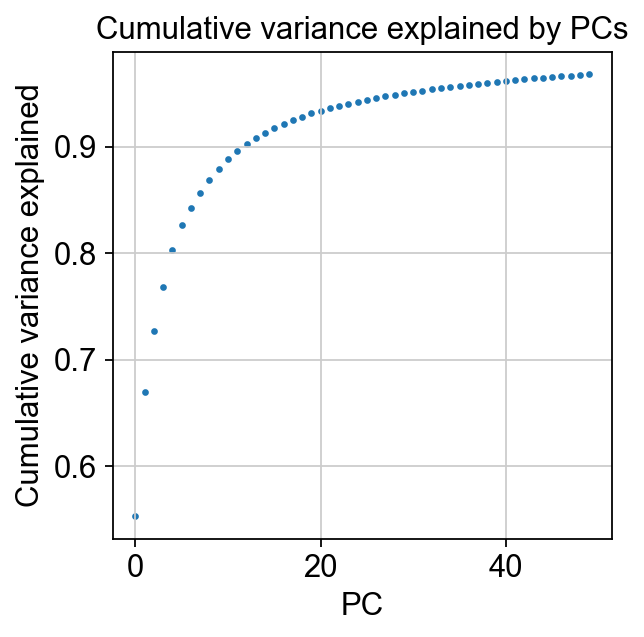

In [37]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [38]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [50]:
k = 15 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 18.987346172332764 seconds
Jaccard graph constructed in 15.194068193435669 seconds
Wrote graph to binary file in 0.05759882926940918 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.818411
Louvain completed 21 runs in 1.6350719928741455 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 47.91548776626587 seconds


In [51]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

In [6]:
# load adata
adata = sc.read_h5ad(pt + '_CD34_cell_features_subclustered.h5ad')

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


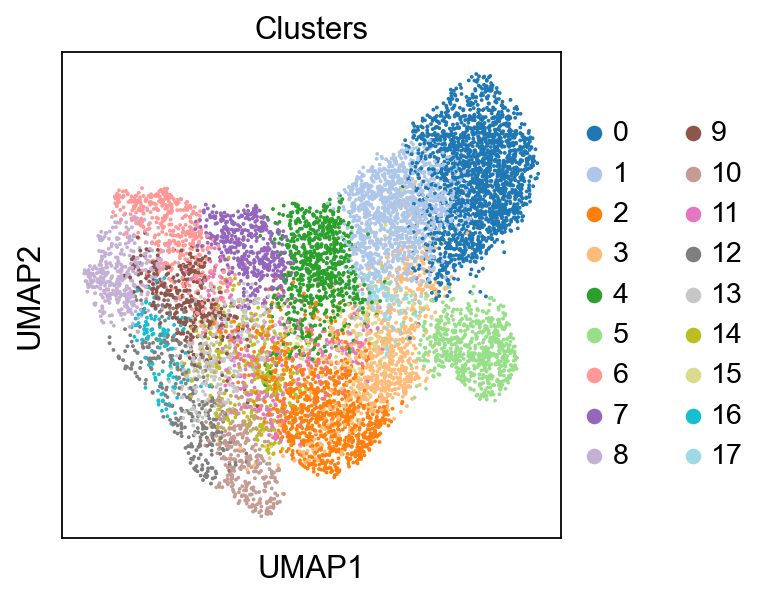

In [7]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

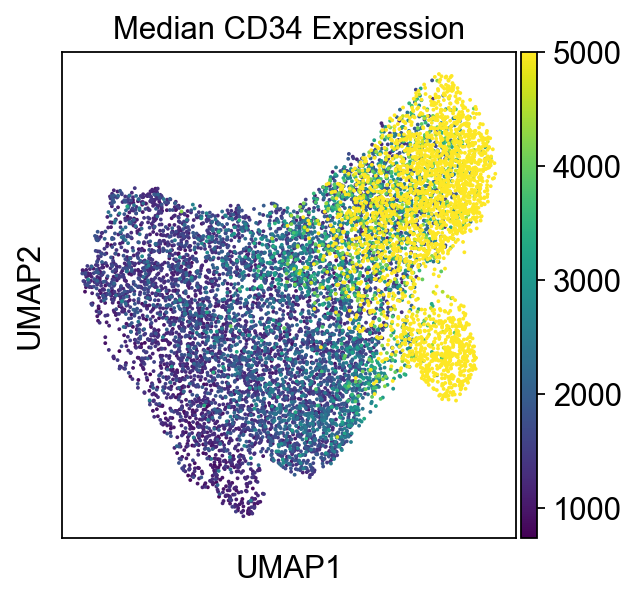

In [8]:
sc.pl.umap(
    adata, 
    color=['CD34_median'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Median CD34 Expression"],
    vmax=5000
)

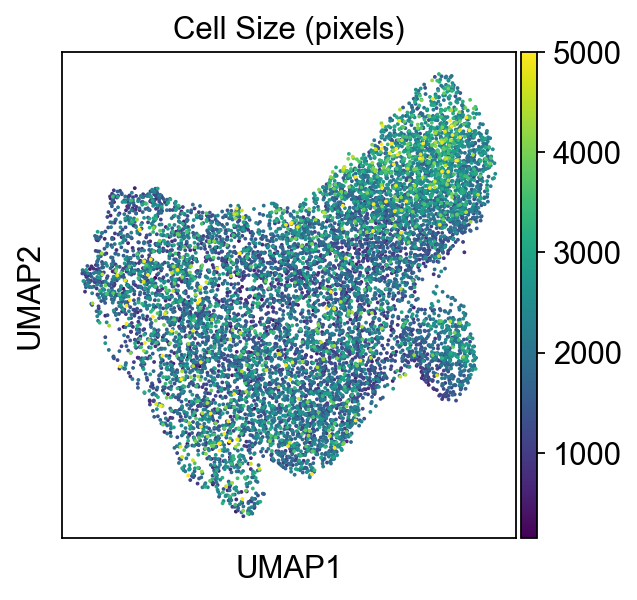

In [9]:
sc.pl.umap(
    adata, 
    color=['Size (pixels)'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Cell Size (pixels)"],
    vmax=5000
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


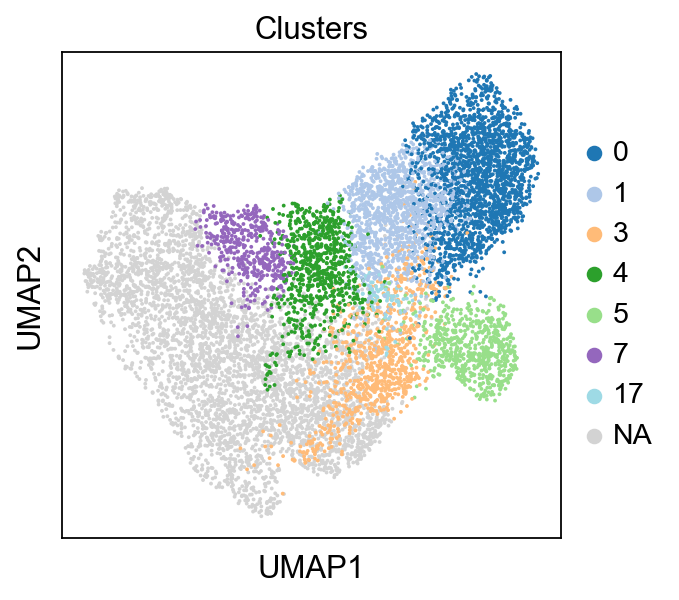

In [10]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[0,1,3,4,5,7,17]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


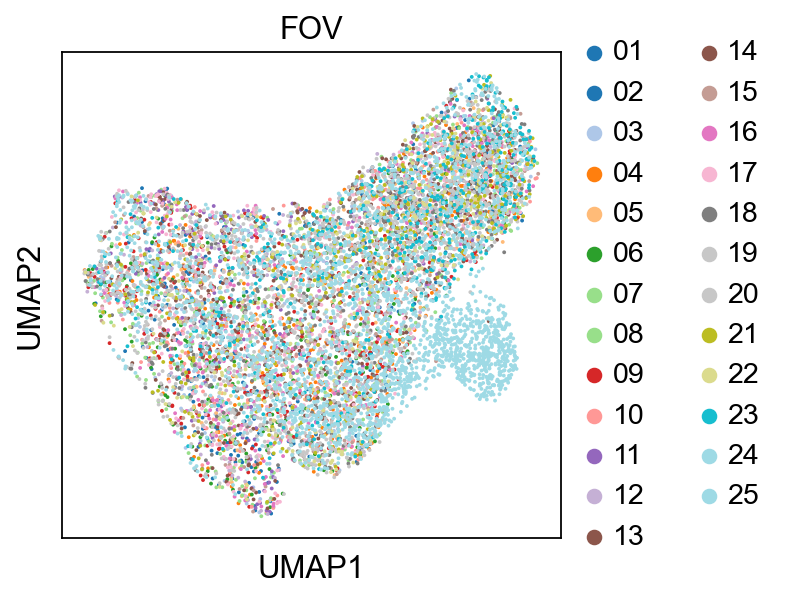

In [11]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [60]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv(pt + '_CD34_subclusters.csv')

In [61]:
# save clustered data anndata object
adata.write_h5ad(pt + '_CD34_cell_features_subclustered.h5ad')